### 1. Setting up the meta-BO environment

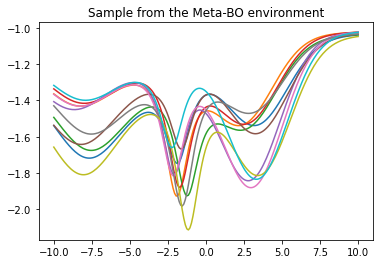

In [6]:
from matplotlib import pyplot as plt
from meta_bo.meta_environment import RandomMixtureMetaEnv
import numpy as np

# setup meta-learning / meta-bo environment
rds = np.random.RandomState(456)
meta_env = RandomMixtureMetaEnv(random_state=rds)

# sample functions / BO tasks from the meta-env
envs = meta_env.sample_envs(num_envs=10)
meta_train_data = meta_env.generate_uniform_meta_train_data(num_tasks=20, num_points_per_task=20)
meta_test_data =  meta_env.generate_uniform_meta_valid_data(num_tasks=50, num_points_context=10, num_points_test=50)

# setup test task
test_env = meta_env.sample_env()
x_context, y_context = test_env.generate_uniform_data(num_points=5)

# visualize samples from the meta-bo env
x_plot = np.linspace(meta_env.domain.l, meta_env.domain.u, 200)
for env in envs:
    plt.plot(x_plot, env.f(x_plot))
plt.title('Sample from the Meta-BO environment')
plt.show()

### 2. Set up a plotting helper function

In [7]:
def plot_regret(evals_stacked: dict, fig_title: str = 'Regret'):
    regret = evals_stacked['y_exact'] - evals_stacked['y_min']
    regret_bp = evals_stacked['y_exact_bp'] - evals_stacked['y_min']

    simple_regret = np.minimum.accumulate(regret, axis=-1)
    cum_regret = np.cumsum(regret, axis=-1)
    cum_regret_bp = np.cumsum(regret_bp, axis=-1)

    fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

    axes[0].plot(simple_regret)
    axes[0].set_ylabel('simple regret')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('t')

    axes[1].plot(cum_regret_bp)
    axes[1].set_ylabel('cumulative inference regret')
    axes[1].set_xlabel('t')
    plt.suptitle(fig_title)
    plt.tight_layout()
    plt.show()

### 3. Run GP-UCB with Vanilla GP

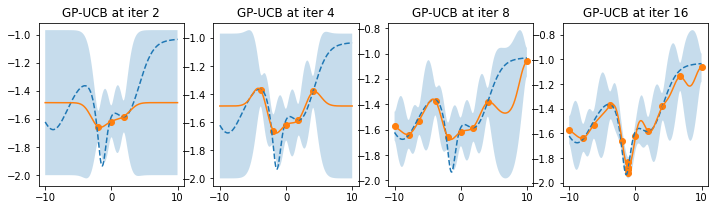

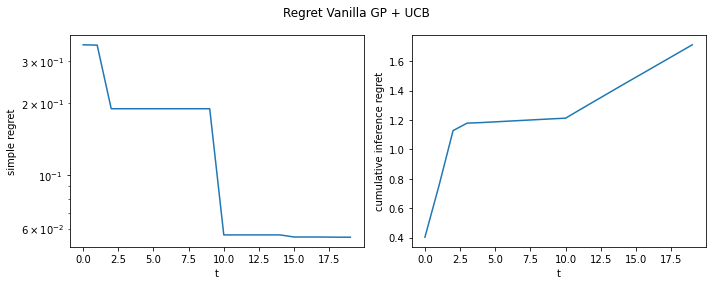

In [9]:
from meta_bo.algorithms.acquisition import UCB
from meta_bo.models.vanilla_gp import GPRegressionVanilla

model = GPRegressionVanilla(input_dim=test_env.domain.d, normalization_stats=test_env.normalization_stats,
                            normalize_data=True, random_state=rds)

# perform BO with the UCB algorithm
algo = UCB(model, test_env.domain, beta=2.0)
evals = []

fig, axes = plt.subplots(ncols=4, figsize=(12, 3))
plt_id = 0
for t in range(20):
    x = algo.next()
    x_bp = algo.best_predicted()
    evaluation = test_env.evaluate(x, x_bp=x_bp)
    evals.append(evaluation)
    evals_stacked = {k: np.array([dic[k] for dic in evals]) for k in evals[0]}

    algo.add_data(evaluation['x'], evaluation['y'])

    if t in [2, 4, 8, 16]:
        x_plot = np.expand_dims(np.linspace(-10, 10, 200), axis=-1)
        pred_mean, pred_std = model.predict(x_plot)
        axes[plt_id].plot(x_plot, test_env.f(x_plot), linestyle='--')
        axes[plt_id].plot(x_plot, pred_mean)
        axes[plt_id].fill_between(np.squeeze(x_plot), pred_mean - 2 * pred_std,
                                  pred_mean + 2 * pred_std, alpha=0.25)
        axes[plt_id].scatter(evals_stacked['x'], evals_stacked['y'], label='BO evaluations')
        axes[plt_id].set_title(f'GP-UCB at iter {t}')
        plt_id += 1
plt.show()

# plt regret
evals_stacked = {k: np.array([dic[k] for dic in evals]) for k in evals[0]}
plot_regret(evals_stacked, 'Regret Vanilla GP + UCB')

### Meta-train F-PACOH and used it for UCB

Iter 1/6000 - Loss: 9.764636 - Time 0.02 sec - Valid-LL: 0.198 - Valid-RMSE: 0.228 - Calib-Err 0.124
Iter 500/6000 - Loss: 3.465680 - Time 7.15 sec - Valid-LL: 0.751 - Valid-RMSE: 0.137 - Calib-Err 0.123
Iter 1000/6000 - Loss: 2.890564 - Time 7.00 sec - Valid-LL: 0.933 - Valid-RMSE: 0.128 - Calib-Err 0.122
Iter 1500/6000 - Loss: 3.149109 - Time 7.11 sec - Valid-LL: 1.126 - Valid-RMSE: 0.123 - Calib-Err 0.116
Iter 2000/6000 - Loss: 3.811162 - Time 7.28 sec - Valid-LL: 1.303 - Valid-RMSE: 0.119 - Calib-Err 0.114
Iter 2500/6000 - Loss: 3.717492 - Time 7.07 sec - Valid-LL: 1.459 - Valid-RMSE: 0.115 - Calib-Err 0.112
Iter 3000/6000 - Loss: 2.846839 - Time 7.02 sec - Valid-LL: 1.558 - Valid-RMSE: 0.119 - Calib-Err 0.121
Iter 3500/6000 - Loss: 2.644540 - Time 7.28 sec - Valid-LL: 1.669 - Valid-RMSE: 0.118 - Calib-Err 0.117
Iter 4000/6000 - Loss: 2.613885 - Time 7.31 sec - Valid-LL: 1.762 - Valid-RMSE: 0.117 - Calib-Err 0.114
Iter 4500/6000 - Loss: 2.700039 - Time 7.13 sec - Valid-LL: 1.837 - 

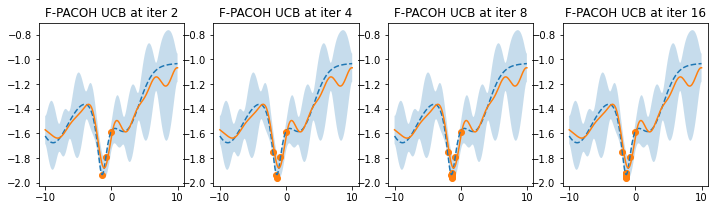

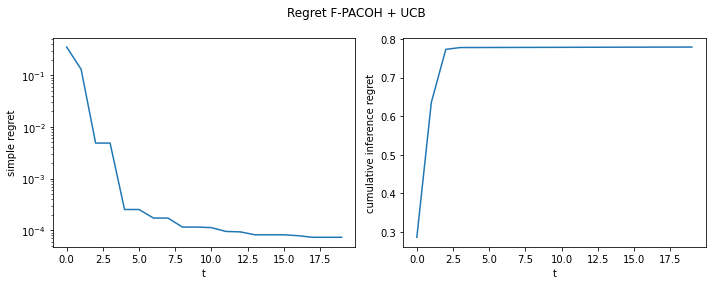

In [10]:
from meta_bo.algorithms.acquisition import UCB
from meta_bo.models.f_pacoh_map import FPACOH_MAP_GP
import warnings

warnings.filterwarnings("ignore") # filter some numerical warnings to make the logs cleaner
NN_LAYERS = (32, 32)
rds_model = np.random.RandomState(345)
fpacoh_model = FPACOH_MAP_GP(domain=meta_env.domain, num_iter_fit=6000, weight_decay=1e-4, prior_factor=0.5,
                             task_batch_size=5, covar_module='NN', mean_module='NN',
                             mean_nn_layers=NN_LAYERS, kernel_nn_layers=NN_LAYERS, random_state=rds_model)

# meta-training for 6000 iterations
fpacoh_model.meta_fit(meta_train_data, meta_valid_tuples=meta_test_data, log_period=500)

# perform BO with the UCB algorithm
algo = UCB(fpacoh_model, test_env.domain, beta=2.0)
evals = []

fig, axes = plt.subplots(ncols=4, figsize=(12, 3))
plt_id = 0
for t in range(20):
    x = algo.next()
    x_bp = algo.best_predicted()
    evaluation = test_env.evaluate(x, x_bp=x_bp)
    evals.append(evaluation)
    evals_stacked = {k: np.array([dic[k] for dic in evals]) for k in evals[0]}

    algo.add_data(evaluation['x'], evaluation['y'])

    if t in [2, 4, 8, 16]:
        x_plot = np.expand_dims(np.linspace(-10, 10, 200), axis=-1)
        pred_mean, pred_std = model.predict(x_plot)
        axes[plt_id].plot(x_plot, test_env.f(x_plot), linestyle='--')
        axes[plt_id].plot(x_plot, pred_mean)
        axes[plt_id].fill_between(np.squeeze(x_plot), pred_mean - 2 * pred_std,
                                  pred_mean + 2 * pred_std, alpha=0.25)
        axes[plt_id].scatter(evals_stacked['x'], evals_stacked['y'], label='BO evaluations')
        axes[plt_id].set_title(f'F-PACOH UCB at iter {t}')
        plt_id += 1
plt.show()

# plt regret
evals_stacked = {k: np.array([dic[k] for dic in evals]) for k in evals[0]}
plot_regret(evals_stacked, fig_title='Regret F-PACOH + UCB')